# Исследование объявлений о продаже квартир

Для исследования предоставлены данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Необходимо научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
# Подключение библиотек

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Настройки

%matplotlib inline

pd.options.display.max_columns = 30
plt.style.use('seaborn-whitegrid')

In [3]:
# Функция разделяет название населённого пункта на "тип" и "имя"

def split_into_parts(row):
    
    row = str(row).split(' ')
    type_loc = []
    title_loc = []
    
    for el in row:
        if el.istitle():
            title_loc.append(el)
        else:
            type_loc.append(el)
    
    loc_type = ' '.join(type_loc)
    loc_title = ' '.join(title_loc)
    my_column = pd.Series([loc_type, loc_title])
    
    return my_column    

In [4]:
# Функция для категоризации населённых пунктов по типу

def categorize_name(row):
    try:
        if ('пос' in row) & ('городск' in row):
            return 'городской посeлок'
        
        elif ('пос' in row) & ('желез' in row):
            return 'поселок станции'
        
        elif ('пос' in row) & ('килом' in row):
            return 'поселок 69 км'
        
        elif ('пос' in row) & ('коттедж' in row):
            return 'коттеджный поселок'
                        
        elif ('пос' in row) & ('станц' in row):
            return 'поселок станции'
        
        elif ('сад' in row) and ('товарищ' in row):
            return 'садовое товарищество'
        
        elif ('село' in row) & (~('посел' in row)):
            return 'село'
        
        elif 'дерев' in row:
            return 'деревня'
        
        elif 'посёл' in row: 
            return 'поселок'
        
        elif 'посел' in row: 
            return 'поселок'
        
        elif '' in row:
            return ''
    except:
        return 'неизвестно'

In [5]:
# Функция для соединения типа населённого пункта и его названия в одну строку

def connect_parts(row):    
    if row['locality_type'] != '':
        row['locality_name'] = row['locality_type'] + ' ' + row['locality_title']
    else:
        row['locality_name'] = row['locality_title']
    return row['locality_name']

In [6]:
# Функция для категоризации этажей по принципу: "первый", "последний", "другой"

def floor_type(row):
    
    floor = row['floor']
    floors_total = row['floors_total_without_nan']
    
    try:
        if floor == 1:
            return 'первый'
        elif floor == floors_total:
            return 'последний'
        else:
            return 'другой'
    except:
        return 'неизвестно'

### Загрузка и просмотр данных

In [7]:
try:
    df = pd.read_csv('real_estate_data.csv', sep='\t')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

In [8]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [9]:
# Общая информация о датасете

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [10]:
# Проверка наличия явных дубликатов

df.duplicated().sum()

0

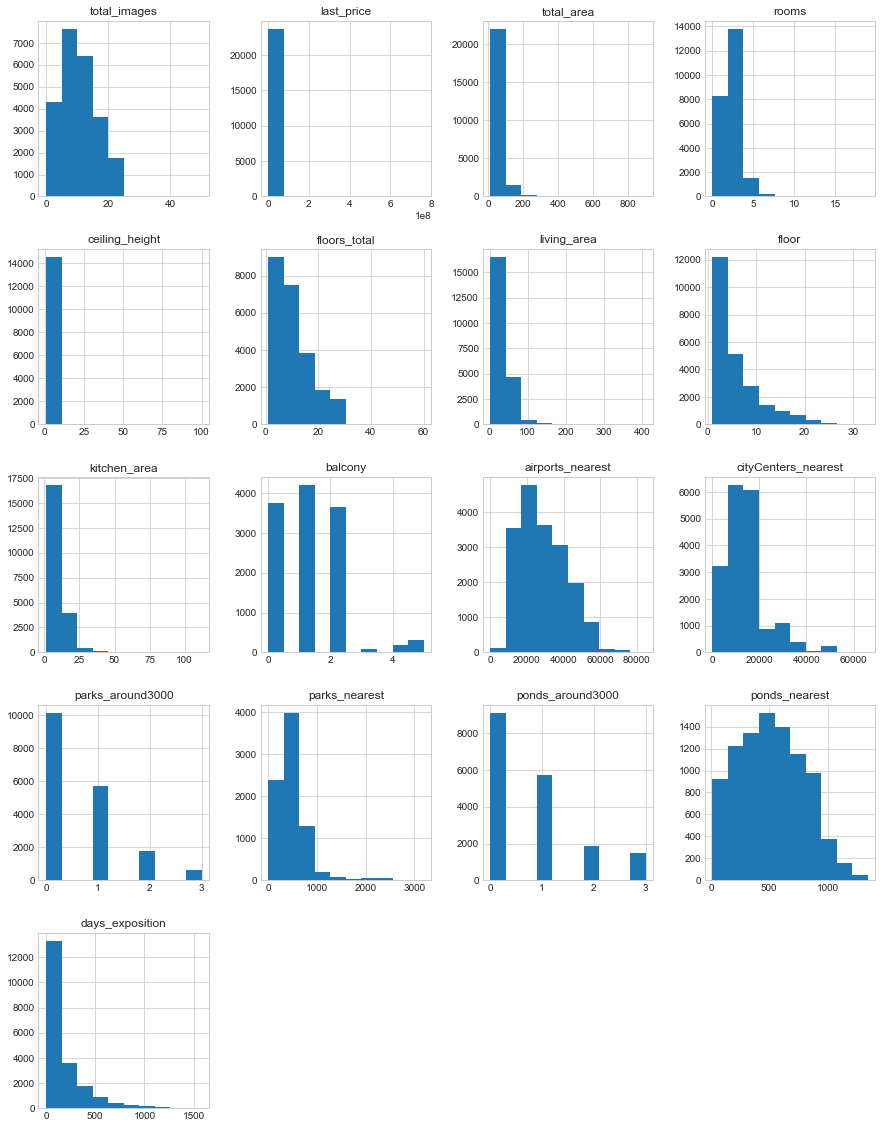

In [11]:
# Общая гистограмма для всех числовых столбцов

df.hist(figsize=(15, 20));

#### Вывод:
Количество строк и столбцов таблицы: 23699 и 22, соответственно. Предварительно можно считать, что этих данных достаточно для исследования.

Названия столбцов соответствуют "хорошему стилю", за исключением столбца `cityCenters_nearest`. Возможно, для удобства анализа информации, следует изменить порядок расположения столбцов, так как некоторые наименования признаков, близких по сути, расположены достаточно далеко друг от друга (например, `total_area`, `living_area`, `kitchen_area` и пр.). 

Пропуски в данных есть (на первый взгляд, как минимум половина столбцов содержит пропуски в разных количествах). Явных дубликатов не обнаружено.

Также есть несоответствия в типах данных: 
- столбцы `floors_total`, `balcony`, `parks_around3000`, `ponds_around3000`, `days_exposition` имеют тип `float`, однако, по смыслу данных предпочтительнее целочисленный тип; 
- столбец `is_apartment` имеет тип `object`, а в описании к датасету для данного столбца указан тип `bool`; 
- столбец `first_day_exposition`(дата публикации) типа `object` логичнее было бы привести к типу `datetime`.   


### Предобработка данных

Переименуем столбец `cityCenters_nearest` и изменим порядок следования столбцов согласно логике данных:

In [12]:
df = df.rename(columns={'cityCenters_nearest': 'city_centers_nearest'})

In [13]:
df = df[['last_price', 'rooms', 'total_area', 'living_area', 'kitchen_area', 'ceiling_height', 'balcony', 
         'is_apartment', 'studio', 'open_plan', 'floor', 'floors_total', 'total_images', 'first_day_exposition', 
         'days_exposition', 'locality_name', 'city_centers_nearest', 'airports_nearest', 'parks_around3000', 
         'parks_nearest', 'ponds_around3000', 'ponds_nearest']]

# Проверка

print(f'Количество столбцов датафрейма равно: {df.shape[1]}')
df.head() 

Количество столбцов датафрейма равно: 22


,last_price,rooms,total_area,living_area,kitchen_area,ceiling_height,balcony,is_apartment,studio,open_plan,floor,floors_total,total_images,first_day_exposition,days_exposition,locality_name,city_centers_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest
0,13000000.0,3,108.0,51.0,25.0,2.70,NaN,NaN,False,False,8,16.0,20,2019-03-07T00:00:00,NaN,Санкт-Петербург,16028.0,18863.0,1.0,482.0,2.0,755.0
1,3350000.0,1,40.4,18.6,11.0,NaN,2.0,NaN,False,False,1,11.0,7,2018-12-04T00:00:00,81.0,посёлок Шушары,18603.0,12817.0,0.0,NaN,0.0,NaN
2,5196000.0,2,56.0,34.3,8.3,NaN,0.0,NaN,False,False,4,5.0,10,2015-08-20T00:00:00,558.0,Санкт-Петербург,13933.0,21741.0,1.0,90.0,2.0,574.0
3,64900000.0,3,159.0,NaN,NaN,NaN,0.0,NaN,False,False,9,14.0,0,2015-07-24T00:00:00,424.0,Санкт-Петербург,6800.0,28098.0,2.0,84.0,3.0,234.0
4,10000000.0,2,100.0,32.0,41.0,3.03,NaN,NaN,False,False,13,14.0,2,2018-06-19T00:00:00,121.0,Санкт-Петербург,8098.0,31856.0,2.0,112.0,1.0,48.0


#### Обработка пропусков, аномалий и неявных дубликатов. Приведение типов данных. 

In [14]:
# Количество пропущенных значений для каждого столбца

df.isna().sum().sort_values()

last_price                  0
first_day_exposition        0
total_images                0
open_plan                   0
studio                      0
floor                       0
total_area                  0
rooms                       0
locality_name              49
floors_total               86
living_area              1903
kitchen_area             2278
days_exposition          3181
ponds_around3000         5518
parks_around3000         5518
city_centers_nearest     5519
airports_nearest         5542
ceiling_height           9195
balcony                 11519
ponds_nearest           14589
parks_nearest           15620
is_apartment            20924
dtype: int64

* #### Признак `locality_name`

Количество пропущенных в столбце значений равно 49, очень мало, по сравнению с общим набором данных. Расположение недвижимости (населенный пункт) вероятно играет существенную роль при формировании цены (в городе дороже, в области - дешевле). Удалим записи, соответствующие пропускам в данном столбце, чтобы они не искажали дальнейшее исследование.

In [15]:
df.dropna(subset=['locality_name'], inplace=True)

In [16]:
# Сброс индексов, с удалением старых индексов

df.reset_index(drop=True, inplace=True)

In [17]:
# Проверка

df['locality_name'].isna().sum()

0

In [18]:
df['locality_name'].value_counts()

locality_name
Санкт-Петербург                    15721
посёлок Мурино                       522
посёлок Шушары                       440
Всеволожск                           398
Пушкин                               369
                                   ...  
поселок Каложицы                       1
посёлок Платформа 69-й километр        1
поселок Почап                          1
поселок Гончарово                      1
посёлок Дзержинского                   1
Name: count, Length: 364, dtype: int64

In [19]:
df['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [20]:
# Создаём два новых столбца, для типа населённого пункта - locality_type и для его названия - locality_name

df[['locality_type', 'locality_title']] = df['locality_name'].apply(split_into_parts)
df[['locality_name', 'locality_type', 'locality_title']].tail(20)

,locality_name,locality_type,locality_title
23630,Сосновый Бор,,Сосновый Бор
23631,Санкт-Петербург,,Санкт-Петербург
23632,Санкт-Петербург,,Санкт-Петербург
23633,Выборг,,Выборг
23634,посёлок Дзержинского,посёлок,Дзержинского
23635,Санкт-Петербург,,Санкт-Петербург
23636,Ломоносов,,Ломоносов
23637,Санкт-Петербург,,Санкт-Петербург
23638,Санкт-Петербург,,Санкт-Петербург
23639,Санкт-Петербург,,Санкт-Петербург


Рассмотри уникальные значения в новых столбцах (тип пункта и его название):

In [21]:
df['locality_type'].sort_values().unique()

array(['', 'городской поселок', 'городской посёлок', 'деревня',
       'коттеджный поселок', 'коттеджный посёлок', 'поселок',
       'поселок городского типа', 'поселок городского типа имени',
       'поселок станции', 'посёлок', 'посёлок 69-й километр',
       'посёлок городского типа', 'посёлок городского типа имени',
       'посёлок при железнодорожной станции', 'посёлок станции',
       'садоводческое некоммерческое товарищество',
       'садовое товарищество', 'село'], dtype=object)

In [22]:
df['locality_type'] = df['locality_type'].apply(categorize_name)
df['locality_type'].sort_values().unique()

array(['', 'городской посeлок', 'деревня', 'коттеджный поселок',
       'поселок', 'поселок 69 км', 'поселок станции',
       'садовое товарищество', 'село'], dtype=object)

In [23]:
df[['locality_name', 'locality_type', 'locality_title']].head(20)

,locality_name,locality_type,locality_title
0,Санкт-Петербург,,Санкт-Петербург
1,посёлок Шушары,поселок,Шушары
2,Санкт-Петербург,,Санкт-Петербург
3,Санкт-Петербург,,Санкт-Петербург
4,Санкт-Петербург,,Санкт-Петербург
5,городской посёлок Янино-1,городской посeлок,Янино-1
6,посёлок Парголово,поселок,Парголово
7,Санкт-Петербург,,Санкт-Петербург
8,посёлок Мурино,поселок,Мурино
9,Санкт-Петербург,,Санкт-Петербург


Группируем данные по названию, и выбираем те населённые пункты, которые содержат несколько значений типов:

In [24]:
df_grouped_title = df.groupby('locality_title')['locality_type'].unique()

In [25]:
df_grouped_title[df.groupby('locality_title')['locality_type'].nunique() > 1]

locality_title
Гарболово                              [деревня, поселок]
Громово                        [поселок станции, поселок]
Зимитицы                               [поселок, деревня]
Калитино                               [деревня, поселок]
Кудрово                                       [деревня, ]
Лесное                      [поселок, коттеджный поселок]
Любань                                        [, поселок]
Мурино                                        [поселок, ]
Никольское                                       [, село]
Павлово                         [село, городской посeлок]
Приладожский    [городской посeлок, садовое товарищество]
Рабитицы                               [деревня, поселок]
Рахья           [городской посeлок, садовое товарищество]
Рябово                       [поселок, городской посeлок]
Фёдоровское                  [деревня, городской посeлок]
Щеглово                                [поселок, деревня]
Name: locality_type, dtype: object

Удалим оставшиеся дубликаты (чтобы понять, какой тип населенного пункта выбрать, ориентировалась на описание в Википедии, т.е. дубликаты, которые остались, по ним была двоякая информация, например, Калитино - есть и поселок, и деревня, и т.д.):

In [26]:
# В комментариях те пункты, по которым не удалось установить единственно верный тип

df.loc[df['locality_title'] == 'Гарболово', 'locality_type'] = 'деревня'
df.loc[df['locality_title'] == 'Громово', 'locality_type'] = 'поселок станции'
#df.loc[df['locality_title'] == 'Зимитицы', 'locality_type'] = '?'
#df.loc[df['locality_title'] == 'Калитино', 'locality_type'] = '?'
df.loc[df['locality_title'] == 'Кудрово', 'locality_type'] = ''
df.loc[df['locality_title'] == 'Лесное', 'locality_type'] = 'поселок'
#df.loc[df['locality_title'] == 'Любань', 'locality_type'] = '?'
df.loc[df['locality_title'] == 'Мурино', 'locality_type'] = ''
#df.loc[df['locality_title'] == 'Никольское', 'locality_type'] = '?'
#df.loc[df['locality_title'] == 'Павлово', 'locality_type'] = '?'
df.loc[df['locality_title'] == 'Приладожский', 'locality_type'] = 'городской посeлок'
#df.loc[df['locality_title'] == 'Рабитицы', 'locality_type'] = '?'
df.loc[df['locality_title'] == 'Рахья', 'locality_type'] = 'городской посeлок'
#df.loc[df['locality_title'] == 'Рябово', 'locality_type'] = '?'
df.loc[df['locality_title'] == 'Фёдоровское', 'locality_type'] = 'городской посeлок'
#df.loc[df['locality_title'] == 'Щеглово', 'locality_type'] = '?'

In [27]:
df_grouped_title[df.groupby('locality_title')['locality_type'].nunique() > 1]

locality_title
Зимитицы                [поселок, деревня]
Калитино                [деревня, поселок]
Любань                         [, поселок]
Никольское                        [, село]
Павлово          [село, городской посeлок]
Рабитицы                [деревня, поселок]
Рябово        [поселок, городской посeлок]
Щеглово                 [поселок, деревня]
Name: locality_type, dtype: object

Обновим столбец `locality_name`, с учетом изменений в данных:

In [28]:
df['locality_name'] = df.apply(connect_parts, axis=1)

In [29]:
df[['locality_name', 'locality_type', 'locality_title']].tail(20)

,locality_name,locality_type,locality_title
23630,Сосновый Бор,,Сосновый Бор
23631,Санкт-Петербург,,Санкт-Петербург
23632,Санкт-Петербург,,Санкт-Петербург
23633,Выборг,,Выборг
23634,поселок Дзержинского,поселок,Дзержинского
23635,Санкт-Петербург,,Санкт-Петербург
23636,Ломоносов,,Ломоносов
23637,Санкт-Петербург,,Санкт-Петербург
23638,Санкт-Петербург,,Санкт-Петербург
23639,Санкт-Петербург,,Санкт-Петербург


In [30]:
# Удалим всп. столбцы

df.drop(['locality_type', 'locality_title'], axis=1, inplace=True)

* #### Признаки `floor` и `floors_total`

In [31]:
# Количество пропусков в столбцах

df[['floor', 'floors_total']].isna().sum()

floor            0
floors_total    85
dtype: int64

Количество пропущенных значений в столбце `floors_total` невелико, а в столбце `floor` пропуски отсутствуют. Для оценки влияния на стоимость кажется предпочтительным столбец `floor`, возможно имеет смысл удалить столбец `floors_total` или попробовать заполнить пропуски медианой?

Сгруппируем данные по этажу и посмотрим на медианные и максимальные значения в столбце `floors_total`:

In [32]:
df.groupby('floor').agg({'floors_total': ['median', 'max']})

floors_total      
            median   max
floor                   
1              5.0  27.0
2              5.0  28.0
3              5.0  35.0
4              5.0  60.0
5              6.0  37.0
6              9.0  28.0
7             10.0  27.0
8             10.0  35.0
9             10.0  35.0
10            16.0  27.0
11            16.0  35.0
12            16.0  35.0
13            17.0  36.0
14            17.0  27.0
15            17.0  35.0
16            18.0  27.0
17            22.0  35.0
18            22.0  52.0
19            24.0  27.0
20            24.0  27.0
21            25.0  27.0
22            25.0  35.0
23            25.0  35.0
24            25.0  28.0
25            25.0  27.0
26            27.0  35.0
27            27.0  35.0
28            36.0  36.0
29            36.0  36.0
30            35.0  35.0
31            35.0  35.0
32            33.0  33.0
33            35.0  35.0

Видно, что для каждого этажа медианное значения общего количества этажей больше, поэтому всё же вместо удаления признака, заменим в нём пропуски на медианы, по сгруппированным (по этажам) данным:

In [33]:
df['floors_total_without_nan'] = df.groupby('floor')['floors_total'].transform(lambda x: x.fillna(x.median()))

In [34]:
df[['floor', 'floors_total', 'floors_total_without_nan']].sort_values(by='floors_total').tail(10)

,floor,floors_total,floors_total_without_nan
20213,2,NaN,5.0
20698,10,NaN,16.0
21232,19,NaN,24.0
21608,19,NaN,24.0
21709,21,NaN,25.0
22496,3,NaN,5.0
22610,20,NaN,24.0
22761,6,NaN,9.0
23541,18,NaN,22.0
23609,8,NaN,10.0


In [35]:
# Проверка на согласованность данных (номер этажа не превышает общее количество этажей)

(df['floor'] > df['floors_total_without_nan']).sum()

0

In [36]:
# Проверка на наличие пропусков

df['floors_total_without_nan'].isna().sum()

0

Далее будем использовать новый столбец `floors_total_without_nan`, тип данных в котором логичнее преобразовать в целочисленный. Также, дополнительно снова переименуем столбцы, чтобы похожие по смыслу признаки стояли рядом:

In [37]:
df['floors_total_without_nan'] = df['floors_total_without_nan'].astype(int)

In [38]:
df = df[['last_price', 'rooms', 'total_area', 'living_area', 'kitchen_area', 'ceiling_height', 'balcony', 
         'is_apartment', 'studio', 'open_plan', 'floor', 'floors_total', 'floors_total_without_nan', 'total_images', 
         'first_day_exposition', 'days_exposition', 'locality_name', 'city_centers_nearest', 'airports_nearest', 
         'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']]

# Проверка

print(f'Количество столбцов датафрейма равно: {df.shape[1]}')
df.head() 

Количество столбцов датафрейма равно: 23


,last_price,rooms,total_area,living_area,kitchen_area,ceiling_height,balcony,is_apartment,studio,open_plan,floor,floors_total,floors_total_without_nan,total_images,first_day_exposition,days_exposition,locality_name,city_centers_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest
0,13000000.0,3,108.0,51.0,25.0,2.70,NaN,NaN,False,False,8,16.0,16,20,2019-03-07T00:00:00,NaN,Санкт-Петербург,16028.0,18863.0,1.0,482.0,2.0,755.0
1,3350000.0,1,40.4,18.6,11.0,NaN,2.0,NaN,False,False,1,11.0,11,7,2018-12-04T00:00:00,81.0,поселок Шушары,18603.0,12817.0,0.0,NaN,0.0,NaN
2,5196000.0,2,56.0,34.3,8.3,NaN,0.0,NaN,False,False,4,5.0,5,10,2015-08-20T00:00:00,558.0,Санкт-Петербург,13933.0,21741.0,1.0,90.0,2.0,574.0
3,64900000.0,3,159.0,NaN,NaN,NaN,0.0,NaN,False,False,9,14.0,14,0,2015-07-24T00:00:00,424.0,Санкт-Петербург,6800.0,28098.0,2.0,84.0,3.0,234.0
4,10000000.0,2,100.0,32.0,41.0,3.03,NaN,NaN,False,False,13,14.0,14,2,2018-06-19T00:00:00,121.0,Санкт-Петербург,8098.0,31856.0,2.0,112.0,1.0,48.0


Посмотрим на статистики признаков, построим графики ("ящик с усами"):

In [39]:
df[['floor', 'floors_total_without_nan']].describe()

,floor,floors_total_without_nan
count,23650.000000,23650.000000
mean,5.893277,10.684059
std,4.883317,6.597081
min,1.000000,1.000000
25%,2.000000,5.000000
50%,4.000000,9.000000
75%,8.000000,16.000000
max,33.000000,60.000000


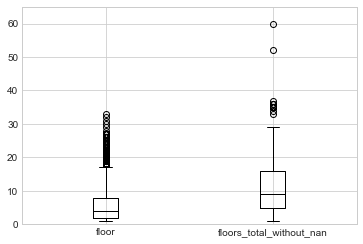

In [40]:
plt.ylim(0, 65)

df.boxplot(column=['floor', 'floors_total_without_nan'], color='black');

В данных есть выбросы. В целом, несмотря на то, что есть информация о ЖК в Санкт-Петербурге высотой в 37 этажей, как правило жилые комплексы имеют количество этажей не больше 30. Не станем удалять значения, превышающие 40, отбросим лишь два чересчур нетипичных значения:

In [41]:
df.loc[df['floors_total_without_nan'] >= 40]['floors_total_without_nan']

2251     60
16701    52
Name: floors_total_without_nan, dtype: int32

In [42]:
df = df.drop(df[df['floors_total_without_nan'] >= 40].index)

In [43]:
df.reset_index(drop=True, inplace=True)

* #### Признаки `total_area`, `living_area` и `kitchen_area`

In [44]:
# Количество пропусков в столбцах

df[['total_area', 'living_area', 'kitchen_area']].isna().sum()

total_area         0
living_area     1898
kitchen_area    2269
dtype: int64

В столбцах с информацией о жилой площади и площади кухни имеются пропуски (1898 и 2269, соотв.), однако, пропуски отсутствуют в столбце `total_area`, есть смысл попробовать заполнить пропуски, опираясь на информацию об общей площади.

Рассмотрим взаимосвязь общей площади, жилой площади и площади кухни. Для этого возьмём срез данных (выберем только те строки, в которых, в указанных признаках, отсутствуют пропуски): 

In [45]:
df_area = df.loc[(df['living_area'].notna()) & (df['kitchen_area'].notna()), ['total_area', 'living_area', 'kitchen_area']]

In [46]:
df_area.isna().sum()

total_area      0
living_area     0
kitchen_area    0
dtype: int64

Строим матрицу рассеяния и находим матрицу корреляции:

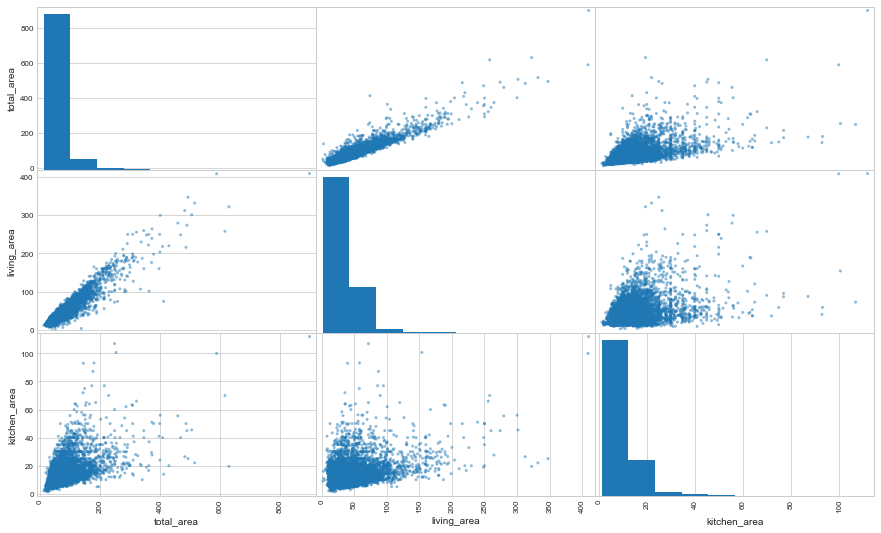

In [47]:
pd.plotting.scatter_matrix(df_area, figsize=(15, 9), grid=True);

In [48]:
df_area.corr()

,total_area,living_area,kitchen_area
total_area,1.000000,0.939496,0.609147
living_area,0.939496,1.000000,0.428816
kitchen_area,0.609147,0.428816,1.000000


Можно наблюдать сильную корреляцию между общей и жилой площадью (коэффициент корреляции 0.94, очень близко к 1), корреляция между общей площадью и площадью кухни также есть, но более слабая (коэффициент корреляции 0.61). Имеет смысл попытаться заполнить пропуски в столбце `living_area` на основании данных столбца `total_area`, а пропуски в столбце `kitchen_area` заполнить разностью значений в первых двух столбцах. 

Для расчёта жилой площади на основе общей вычислим для каждой не пустой пары "общая площадь - жилая площадь" во сколько раз 
общая площадь больше жилой, а затем медиану получившейся выборки. Заменим пропуски в столбце `living_area` на значение медианы.

In [49]:
part_living_area_from_total = df_area['total_area'] / df_area['living_area'] # во сколько раз общая площадь больше жилой
part_living_area_from_total.median().round(2) 

1.77

In [50]:
df[['total_area', 'living_area', 'kitchen_area']].describe()

,total_area,living_area,kitchen_area
count,23648.000000,21750.000000,21379.000000
mean,60.330556,34.449781,10.566390
std,35.662941,22.038028,5.901942
min,12.000000,2.000000,1.300000
25%,40.000000,18.600000,7.000000
50%,52.000000,30.000000,9.100000
75%,69.702500,42.300000,12.000000
max,900.000000,409.700000,112.000000


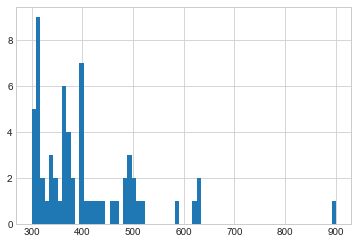

In [51]:
df['total_area'].hist(range=(300, 900), bins=70);

In [52]:
df.loc[df['total_area'] > 650]

,last_price,rooms,total_area,living_area,kitchen_area,ceiling_height,balcony,is_apartment,studio,open_plan,floor,floors_total,floors_total_without_nan,total_images,first_day_exposition,days_exposition,locality_name,city_centers_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest
19503,420000000.0,12,900.0,409.7,112.0,2.8,NaN,NaN,False,False,25,25.0,25,8,2017-12-06T00:00:00,106.0,Санкт-Петербург,7877.0,30706.0,0.0,NaN,2.0,318.0


Удалим записи, соотв. величине общей площади более 650 кв. метров (например, по данным в СПб, самая большая площадь квартиры составляет 631 кв. метр, а самая маленькая квартира-студия имеет площадь 12 кв. метров): 

In [53]:
df = df.drop(df[df['total_area'] == 900].index)

In [54]:
df.reset_index(drop=True, inplace=True)

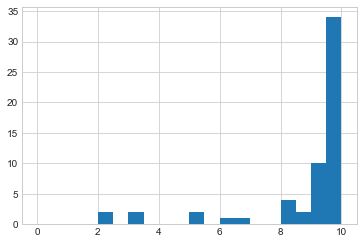

In [55]:
df['living_area'].hist(range=(0, 10), bins=20);

In [56]:
df.query('living_area < 8').groupby('rooms')['living_area'].count()

rooms
0    2
1    3
2    1
3    1
4    1
Name: living_area, dtype: int64

Удалим записи, соотв. величине общей площади менее 8 кв. метров (например, по данным в СПб, самая большая площадь квартиры составляет 631 кв. метр, а самая маленькая квартира-студия имеет площадь 12 кв. метров):

In [57]:
df = df.drop(df[df['living_area'] < 8].index)

In [58]:
df.reset_index(drop=True, inplace=True)

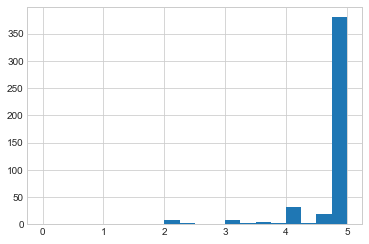

In [59]:
df['kitchen_area'].hist(range=(0, 5), bins=20);

In [60]:
df.query('kitchen_area < 3').groupby('rooms')['kitchen_area'].count()

rooms
1    9
2    2
Name: kitchen_area, dtype: int64

In [61]:
df.loc[df['kitchen_area'] < 3]

,last_price,rooms,total_area,living_area,kitchen_area,ceiling_height,balcony,is_apartment,studio,open_plan,floor,floors_total,floors_total_without_nan,total_images,first_day_exposition,days_exposition,locality_name,city_centers_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest
906,2600000.0,1,27.00,18.0,2.00,2.75,0.0,NaN,False,False,18,23.0,23,15,2017-07-10T00:00:00,10.0,Санкт-Петербург,17459.0,22131.0,0.0,NaN,1.0,411.0
6250,3100000.0,2,24.00,16.0,2.00,3.00,NaN,NaN,False,False,5,5.0,5,9,2018-06-25T00:00:00,54.0,Санкт-Петербург,4914.0,31960.0,2.0,426.0,1.0,936.0
7934,5967734.0,2,66.40,44.4,2.89,NaN,NaN,False,False,False,2,4.0,4,3,2017-02-07T00:00:00,335.0,Санкт-Петербург,20802.0,44870.0,0.0,NaN,0.0,NaN
8712,2200000.0,1,18.40,14.0,2.40,2.52,NaN,NaN,False,False,3,3.0,3,9,2018-08-20T00:00:00,59.0,Пушкин,30687.0,20710.0,0.0,NaN,1.0,155.0
9120,2920000.0,1,23.29,21.0,2.00,NaN,NaN,NaN,False,False,1,3.0,3,17,2018-12-12T00:00:00,107.0,Санкт-Петербург,4008.0,19506.0,0.0,NaN,2.0,45.0
11013,5350000.0,1,32.00,16.0,2.00,NaN,0.0,NaN,False,False,10,14.0,14,6,2016-04-20T00:00:00,210.0,Санкт-Петербург,3953.0,19008.0,0.0,NaN,1.0,69.0
16337,2720000.0,1,25.70,22.6,2.00,NaN,NaN,NaN,False,False,11,19.0,19,2,2017-10-30T00:00:00,109.0,Санкт-Петербург,13268.0,14472.0,0.0,NaN,0.0,NaN
17796,2940000.0,1,34.70,15.5,2.30,NaN,1.0,NaN,False,False,14,26.0,26,5,2017-10-09T00:00:00,318.0,Мурино,NaN,NaN,NaN,NaN,NaN,NaN
19599,1190000.0,1,14.00,11.0,2.00,NaN,NaN,NaN,False,False,1,5.0,5,5,2018-07-29T00:00:00,4.0,Санкт-Петербург,11122.0,9898.0,0.0,NaN,0.0,NaN
20172,4250000.0,1,28.50,19.5,1.30,2.80,NaN,NaN,False,False,10,14.0,14,7,2019-05-01T00:00:00,NaN,Санкт-Петербург,12721.0,37199.0,0.0,NaN,0.0,NaN


Все объекты с очень маленькими кухнями не являются ни студиями, ни квартирами с открытой планировкой. За икслючением двух объектов в выборке, все остальные имеют одну комнату, можно предположить, учитывая общую площадь и стоимость, что это всё же студии. В случае "двушек" заменим аномальные значения площади кухни на квантиль, в остальных случаях - поставим пропуски, а в столбце `studio` изменим соответствующее значение на True.

In [62]:
df['kitchen_area'].quantile(0.25)

7.0

In [63]:
df.loc[(df['kitchen_area'] < 3) & (df['rooms'] == 2), 'kitchen_area'] = df['kitchen_area'].quantile(0.25)

In [64]:
df.loc[df['kitchen_area'] < 3, 'studio'] = True

In [65]:
df.loc[df['kitchen_area'] < 3, 'kitchen_area'] = np.nan

In [66]:
df.loc[df['kitchen_area'] < 3, 'kitchen_area'].count()

0

In [67]:
df[['total_area', 'living_area', 'kitchen_area']].describe()

,total_area,living_area,kitchen_area
count,23639.000000,21741.000000,21363.000000
mean,60.297745,34.443684,10.564863
std,35.242297,21.887412,5.859638
min,12.000000,8.000000,3.000000
25%,40.000000,18.600000,7.000000
50%,52.000000,30.000000,9.100000
75%,69.700000,42.300000,12.000000
max,631.200000,409.000000,107.000000


In [68]:
df[['total_area', 'living_area', 'kitchen_area']].isna().sum()

total_area         0
living_area     1898
kitchen_area    2276
dtype: int64

In [69]:
# Зааполняем пропуски в признаке "жилая площадь"

df['living_area'] = df['living_area'].fillna(df['total_area'] / part_living_area_from_total.median().round(2)) 

In [70]:
# Проверка

df[['living_area', 'kitchen_area']].isna().sum()

living_area        0
kitchen_area    2276
dtype: int64

Пропуски в признаке `kitchen_area` заполним по принципу: общая площадь - жилая площадь - константа (небольшой запас на др. помещения, к примеру, ванна, туалет и т.п.), в тех случаях, когда квартира не студия и не отк. планировки, в остальных случаях оставим пропуски в этом признаке:

In [71]:
condition = ((df['kitchen_area'].isna()) & (df['studio'] == False) & (df['open_plan'] == False) & (df['total_area'] - df['living_area'] > 8))

df.loc[condition, 'kitchen_area'] = df.loc[condition, 'total_area'] - df.loc[condition, 'living_area'] - 3

In [72]:
# Проверка на наличие ошибок

df.loc[df['kitchen_area'] < 0]['kitchen_area'].count()

0

In [73]:
df[['living_area', 'kitchen_area']].isna().sum()

living_area       0
kitchen_area    323
dtype: int64

In [74]:
df[['total_area', 'living_area', 'kitchen_area']].describe()

,total_area,living_area,kitchen_area
count,23639.000000,23639.000000,23316.000000
mean,60.297745,34.547532,11.619099
std,35.242297,22.196718,8.416856
min,12.000000,7.344633,3.000000
25%,40.000000,19.000000,7.200000
50%,52.000000,30.000000,9.800000
75%,69.700000,42.100000,12.900000
max,631.200000,409.000000,227.000000


* #### Признак `rooms`

In [75]:
df['rooms'].value_counts()

rooms
1     8032
2     7922
3     5796
4     1174
5      326
0      195
6      105
7       59
8       12
9        8
10       3
11       2
14       2
15       1
19       1
16       1
Name: count, dtype: int64

В данных преобладают квартиры с числом комнат от одной до трёх, однако, есть и нетипичные значения, например, количество комнат равное 0, или большее 6.

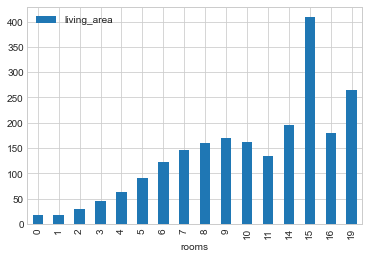

In [76]:
# График зависимости количества комнат и величины жилой площади

(
    df
    .pivot_table(index='rooms', values='living_area', aggfunc='median')
    .plot(kind='bar', grid=True)
);

In [77]:
df['rooms'].describe()

count    23639.000000
mean         2.069927
std          1.076588
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Чем больше площадь квартиры, тем больше количество комнат, такая тенденция наблюдается для объектов, с количеством комнат, не превосходящим 9. Для квартир с 10 и более этажами распределение хаотично, но и самих объектов слишком мало, всего 10 шт. Оставим эти значения без изменений. 

In [78]:
# Всего 195 квартир с кол-вом комнат равным 0

df.loc[df['rooms'] == 0, 'rooms'].count()

195

In [79]:
# Группируем данные по признаку rooms, подсчитаем, сколько объектов явл. студиями или имеют откр. планировку

df.groupby('rooms')[['studio', 'open_plan']].count().head()

,studio,open_plan
rooms,,
0,195,195
1,8032,8032
2,7922,7922
3,5796,5796
4,1174,1174


Получается, все объекты, для которых в признаке rooms стоит 0, это или студии, или квартиры с откр. планировкой. В таком случае нулевое значение логично, заменять не будем.

In [80]:
df['rooms'].value_counts()

rooms
1     8032
2     7922
3     5796
4     1174
5      326
0      195
6      105
7       59
8       12
9        8
10       3
11       2
14       2
15       1
19       1
16       1
Name: count, dtype: int64

* #### Признаки `days_exposition` и `first_day_exposition`

In [81]:
# Количество пропусков в столбце

df['days_exposition'].isna().sum()

3180

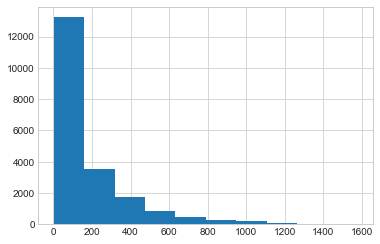

In [82]:
df['days_exposition'].hist();

In [83]:
df['days_exposition'] = df['days_exposition'].fillna(-1) # временно для построения графика

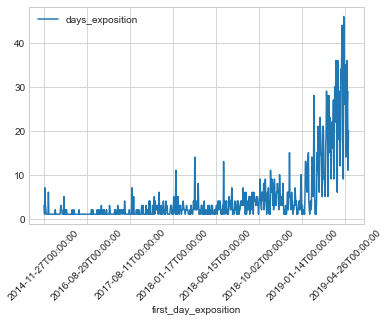

In [84]:
# График зависимости количества пропущенных значений признака days_exposition от даты публикации объявления

(
    df.query('days_exposition == -1')
    .pivot_table(index='first_day_exposition', values='days_exposition', aggfunc='count')
    .plot(rot=45, grid=True)
);

Судя по графику, можно предположить, что пропуски в столбце `days_exposition` обусловлены тем, что данные объявления ещё не сняты с публикации. Таким образом, нет возможности предложить логичную замену пропусков, оставим, как есть.

In [85]:
# Обратная замена

df.loc[df['days_exposition'] == -1, 'days_exposition'] = np.nan

In [86]:
# Проверка

df['days_exposition'].isna().sum()

3180

Преобразуем тип столбца `first_day_exposition` в тип `datetime`:

In [87]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [88]:
df['first_day_exposition'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 23639 entries, 0 to 23638
Series name: first_day_exposition
Non-Null Count  Dtype         
--------------  -----         
23639 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 184.8 KB


* #### Признаки `city_centers_nearest`, `airports_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest` 

In [89]:
df[['city_centers_nearest', 'airports_nearest', 'parks_around3000', 'parks_nearest', 
    'ponds_around3000', 'ponds_nearest']].tail(10)

,city_centers_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest
23629,16081.0,17284.0,1.0,353.0,2.0,652.0
23630,6263.0,20151.0,1.0,300.0,0.0,NaN
23631,4489.0,19424.0,0.0,NaN,1.0,806.0
23632,NaN,NaN,NaN,NaN,NaN,NaN
23633,34104.0,45602.0,1.0,352.0,1.0,675.0
23634,4232.0,24665.0,1.0,796.0,3.0,381.0
23635,NaN,NaN,NaN,NaN,NaN,NaN
23636,NaN,NaN,NaN,NaN,NaN,NaN
23637,10364.0,39140.0,2.0,173.0,3.0,196.0
23638,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
condition = (df['city_centers_nearest'].isna()) & (df['airports_nearest'].isna()) & (df['parks_nearest'].isna()) & (df['ponds_nearest'].isna())

df_cartographic = df.loc[condition, ['city_centers_nearest', 'airports_nearest', 'parks_around3000', 'parks_nearest', 
    'ponds_around3000', 'ponds_nearest']]
df_cartographic.isna().sum()

city_centers_nearest    5509
airports_nearest        5509
parks_around3000        5509
parks_nearest           5509
ponds_around3000        5509
ponds_nearest           5509
dtype: int64

In [91]:
df[['parks_around3000', 'parks_nearest']].isna().sum()

parks_around3000     5509
parks_nearest       15582
dtype: int64

In [92]:
df.loc[(df['parks_nearest'].isna()) & (df['parks_around3000'] == 0), 'parks_around3000'].count()

10073

In [93]:
df[['ponds_around3000', 'ponds_nearest']].isna().sum()

ponds_around3000     5509
ponds_nearest       14559
dtype: int64

In [94]:
df.loc[(df['ponds_nearest'].isna()) & (df['ponds_around3000'] == 0), 'ponds_around3000'].count()

9050

In [95]:
df[['city_centers_nearest', 'airports_nearest']].isna().sum()

city_centers_nearest    5510
airports_nearest        5533
dtype: int64

In [96]:
df.loc[(df['city_centers_nearest'].isna()) & (~df['airports_nearest'].isna()), ['city_centers_nearest', 'airports_nearest']]

,city_centers_nearest,airports_nearest
20145,NaN,15527.0


In [97]:
df.loc[(~df['city_centers_nearest'].isna()) & (df['airports_nearest'].isna()), ['city_centers_nearest', 'airports_nearest']]

,city_centers_nearest,airports_nearest
733,13355.0,NaN
974,9734.0,NaN
2412,13355.0,NaN
7506,5735.0,NaN
7527,13355.0,NaN
8002,5735.0,NaN
8611,5735.0,NaN
9036,9734.0,NaN
9861,4892.0,NaN
10649,21377.0,NaN


Получается, есть 5509 строк, в которых пропущены значения по всем картографическим признакам. Эти значения никак не восстановить без дополнительной информации, их оставим без изменения.

Что касается информации относительно парков и водоёмов, то можно разделить пропуски на те, которые упоминались выше (нет значений во всех картографических признаках), и на пропуски в столбцах `parks_nearest`, `ponds_nearest`, которые соответствуют значениям 0 в столбцах `parks_around3000`, `ponds_around3000` (нет парков/водоёмов в радиусе 3 км.). В таком случае, оставим пропуски, так как сложно предложить разумную замену (возможно какая-то константа, заведомо превышающая 3000 м.???).

In [98]:
df.loc[(df['parks_nearest'].isna()) & (df['parks_around3000'] == 0), 'parks_nearest'] = np.nan

In [99]:
df.loc[(df['ponds_nearest'].isna()) & (df['ponds_around3000'] == 0), 'ponds_nearest'] = np.nan

In [100]:
# Проверка

df[['parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']].isna().sum()

parks_around3000     5509
parks_nearest       15582
ponds_around3000     5509
ponds_nearest       14559
dtype: int64

* #### Признак `ceiling_height`

In [101]:
df['ceiling_height'].isna().sum()

9157

In [102]:
df['ceiling_height'].describe()

count    14482.000000
mean         2.771304
std          1.261933
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

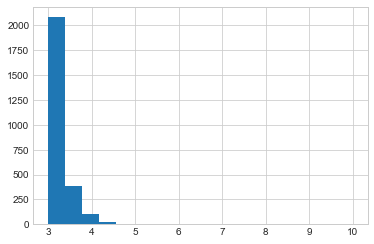

In [103]:
df['ceiling_height'].hist(range=(3, 10), bins=18)
plt.minorticks_on()

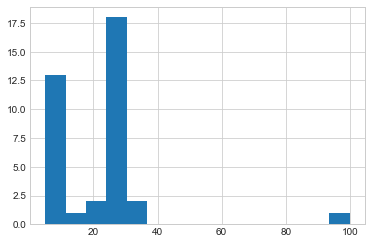

In [104]:
df['ceiling_height'].hist(range=(5, 100), bins=15)
plt.minorticks_on()

In [105]:
df.loc[df['ceiling_height'] > 40]

,last_price,rooms,total_area,living_area,kitchen_area,ceiling_height,balcony,is_apartment,studio,open_plan,floor,floors_total,floors_total_without_nan,total_images,first_day_exposition,days_exposition,locality_name,city_centers_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest
22812,15000000.0,1,25.0,14.0,11.0,100.0,5.0,True,False,False,5,5.0,5,0,2018-07-25,19.0,Санкт-Петербург,8283.0,34963.0,1.0,223.0,3.0,30.0


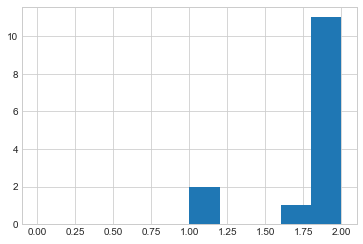

In [106]:
df['ceiling_height'].hist(range=(0, 2))
plt.minorticks_on()

In [107]:
df.query('15 < ceiling_height < 40').groupby('ceiling_height')['ceiling_height'].count()

ceiling_height
20.0    1
22.6    1
24.0    1
25.0    7
26.0    1
27.0    8
27.5    1
32.0    2
Name: ceiling_height, dtype: int64

In [108]:
df.query('1 <= ceiling_height < 2').groupby('ceiling_height')['ceiling_height'].count()

ceiling_height
1.00    1
1.20    1
1.75    1
Name: ceiling_height, dtype: int64

Что касается аномалий в признаке: есть одна квартира с высотой потолка 100 м., некоторые данные по этому объекту также вызывают сомнения (слишком высокая стоимость для однокомнатной квартиры площадью 25 кв. м.) - удалим соответствующую запись. Имеются объекты недвижимости с высотой от 5 до 10 м. - 12 шт, существование такой недвижимости можно допустить. Однако потолки с высотой более 10 м. уже вызывают сомнение. Большое кол-во объектов в диапазоне от 25 до 35 м. позволяет предположить, что вероятнее всего - это объекты с типичной высотой потолка от 2,5 до 3 м., по которым возникла ошибка с разделителем целой и дробной части. 
Также есть квартиры с высотой потолков менее 2 м, что тоже сомнительно. Подобные нетипичные значения заменим на NaN. Пропуски оставим, так как заполнение такого количества данных, с явным наличием выбросов, на какую-то статистику может сильно их исказить.

In [109]:
df = df.drop(df[df['ceiling_height'] == 100].index)

In [110]:
df.reset_index(drop=True, inplace=True)

In [111]:
df.loc[(df['ceiling_height'] >= 10) & (df['ceiling_height'] <= 15), 'ceiling_height'] = np.nan
df.loc[df['ceiling_height'] < 2 , 'ceiling_height'] = np.nan
df.loc[(df['ceiling_height'] >= 20) & (df['ceiling_height'] <= 35), 'ceiling_height'] = df['ceiling_height'] / 10

* #### Признак `balcony`

In [112]:
df['balcony'].isna().sum()

11504

In [113]:
df['balcony'].value_counts()

balcony
1.0    4186
0.0    3725
2.0    3657
5.0     303
4.0     182
3.0      81
Name: count, dtype: int64

Количество квартир с 0, 1 и 2 балконами примерно одинаково. Количество пропусков составляет почти 50% всех данных, если предположить, что пропуски соответствуют отсутствию балконов, и заменить на нули, получим сильный перекос в данных, в сторону квартир без балконов. Возможно имеет смысл заменить на 0 только те пропуски, которые соответствуют квартирам на первом этаже, а остальные оставить без изменения.

Сгруппируем объекты по этажам и посмотрим, какое количество балконов преобладает в каждой группе:

In [114]:
df[(~df['balcony'].isna())].pivot_table(index='floor', columns='balcony', values='last_price', aggfunc='count').head(10)

balcony,0.0,1.0,2.0,3.0,4.0,5.0
floor,,,,,,
1,601.0,130.0,231.0,2.0,7.0,15.0
2,588.0,604.0,325.0,7.0,18.0,37.0
3,495.0,623.0,365.0,6.0,28.0,32.0
4,443.0,594.0,352.0,16.0,26.0,16.0
5,408.0,568.0,342.0,11.0,20.0,28.0
6,169.0,236.0,268.0,7.0,10.0,19.0
7,186.0,241.0,241.0,7.0,9.0,23.0
8,132.0,215.0,221.0,6.0,15.0,21.0
9,165.0,212.0,236.0,3.0,7.0,15.0


Видно, что отсутствие балконов характерно для объектов, расположенных на этажах с первого по пятый, однако, только для первого этажа эта величина превышает остальные, тогда как уже начиная со второго этажа начинают преобладать объекты хотя бы с одним балконом. Заменим на 0 те пропуски, которые соответствуют первому этажу:

In [115]:
df.loc[(df['balcony'].isna()) & (df['floor'] == 1), 'balcony'] = 0

In [116]:
# Проверка

df['balcony'].isna().sum()

9580

* #### Признак `is_apartment`

In [117]:
df['is_apartment'].isna().sum()

20879

In [118]:
df['is_apartment'].value_counts()

is_apartment
False    2710
True       49
Name: count, dtype: int64

Количество апартаментов весьма мало, по сравнению с количеством обычных квартир, и составляет очень малую часть от общего количества объектов. Думаю, логично предположить, что пропуски в данных соответствуют обычным квартирам и заменить их на False. Также, заменим тип данных в столбце на булев тип. 

In [119]:
df['is_apartment'] = df['is_apartment'].fillna(False)

In [120]:
# Проверка

df['is_apartment'].isna().sum()

0

In [121]:
df['is_apartment'] = df['is_apartment'].astype(bool)

In [122]:
df['is_apartment'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 23638 entries, 0 to 23637
Series name: is_apartment
Non-Null Count  Dtype
--------------  -----
23638 non-null  bool 
dtypes: bool(1)
memory usage: 23.2 KB


#### Вывод:
Проведён первичный анализ данных. Там, где это было возможно, устранены пропуски и обработаны нетипичные(аномальные) значения ряда признаков.

- Обработан признак `locality_name`: названия населенных пунктов приведены к единому стилю, удалены неявные дубликаты, удалены пропуски;

- На основании данных признака `floor` заполнены пропуски в признаке `floors_total` медианными значениями (с этой целью сформирован столбец `floors_total_without_nan`, без пропусков, данные приведены к целочисленному типу);

- С учетом сведений о корреляции, на основании данных признакак `total_area` заполнены пропуски в столбце `living_area`, обработаны аномальные значения, связанные с наличием ряда объектов, у которых общая площадь либо совпадала, либо мало отличалась от жилой;

- В следствии зависимости Чем больше площадь квартиры, тем больше количество комнат Нулевые значения в признаке заменены на 1 ()

### Генерация новых признаков

* цена одного квадратного метра

Создадим новый признак `price_per_meter`, поделив значения из `last_price` на `total_area` (округление до одного знака после запятой):

In [123]:
df['price_per_meter'] = (df['last_price'] / df['total_area']).round(1)
df.head()

,last_price,rooms,total_area,living_area,kitchen_area,ceiling_height,balcony,is_apartment,studio,open_plan,floor,floors_total,floors_total_without_nan,total_images,first_day_exposition,days_exposition,locality_name,city_centers_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,price_per_meter
0,13000000.0,3,108.0,51.000000,25.000000,2.70,NaN,False,False,False,8,16.0,16,20,2019-03-07,NaN,Санкт-Петербург,16028.0,18863.0,1.0,482.0,2.0,755.0,120370.4
1,3350000.0,1,40.4,18.600000,11.000000,NaN,2.0,False,False,False,1,11.0,11,7,2018-12-04,81.0,поселок Шушары,18603.0,12817.0,0.0,NaN,0.0,NaN,82920.8
2,5196000.0,2,56.0,34.300000,8.300000,NaN,0.0,False,False,False,4,5.0,5,10,2015-08-20,558.0,Санкт-Петербург,13933.0,21741.0,1.0,90.0,2.0,574.0,92785.7
3,64900000.0,3,159.0,89.830508,66.169492,NaN,0.0,False,False,False,9,14.0,14,0,2015-07-24,424.0,Санкт-Петербург,6800.0,28098.0,2.0,84.0,3.0,234.0,408176.1
4,10000000.0,2,100.0,32.000000,41.000000,3.03,NaN,False,False,False,13,14.0,14,2,2018-06-19,121.0,Санкт-Петербург,8098.0,31856.0,2.0,112.0,1.0,48.0,100000.0


* день недели (0 - пн, 1 - вт и т.д.), месяц и год публикации объявления 

Создадим новые признаки `first_exposition_day_week`, `first_exposition_month`, `first_exposition_year`, извлекая соответствующие данные из признака `first_day_exposition`:

In [124]:
df['first_exposition_day_week'] = df['first_day_exposition'].dt.weekday
df['first_exposition_month'] = df['first_day_exposition'].dt.month
df['first_exposition_year'] = df['first_day_exposition'].dt.year

df[['first_day_exposition', 'first_exposition_day_week', 'first_exposition_month', 'first_exposition_year']].head()

,first_day_exposition,first_exposition_day_week,first_exposition_month,first_exposition_year
0,2019-03-07,3,3,2019
1,2018-12-04,1,12,2018
2,2015-08-20,3,8,2015
3,2015-07-24,4,7,2015
4,2018-06-19,1,6,2018


* тип этажа квартиры (значения - "первый", "последний", "другой")

Функцию для категоризации этажей по указанному принципу, применим к датафрейму:

In [125]:
df['floor_category'] = df.apply(floor_type, axis=1)
df[['floor', 'floors_total_without_nan', 'floor_category']].head()

,floor,floors_total_without_nan,floor_category
0,8,16,другой
1,1,11,первый
2,4,5,другой
3,9,14,другой
4,13,14,другой


* расстояние до центра города в километрах (перевести м в км, округлить до целых значений)

Создадим новый признак `city_centers_nearest_km`, поделив значения из `city_centers_nearest` на 1000 (округление до целого):

In [126]:
df['city_centers_nearest_km'] = (df['city_centers_nearest'] / 1000).round()
df[['city_centers_nearest', 'city_centers_nearest_km']].head()

,city_centers_nearest,city_centers_nearest_km
0,16028.0,16.0
1,18603.0,19.0
2,13933.0,14.0
3,6800.0,7.0
4,8098.0,8.0


#### Вывод:
Посчитаны и добавлены новые признаки:

- цена одного квадратного метра `price_per_meter`;
- день недели `first_exposition_day_week`, месяц `first_exposition_month` и год `first_exposition_year` публикации объявления;
- тип этажа квартиры `floor_category`;
- расстояние до центра города в километрах `city_centers_nearest_km`.

### Исследовательский анализ данных

* Изучим следующие параметры объектов: общая площадь, жилая площадь, площадь кухни, цена объекта, количество комнат, высота потолков.

In [127]:
df[['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,living_area,kitchen_area,last_price,rooms,ceiling_height
count,23638.000000,23638.000000,23315.000000,2.363800e+04,23638.000000,14476.000000
mean,60.299238,34.548401,11.619125,6.521708e+06,2.069972,2.727838
std,35.242294,22.196785,8.417035,1.055504e+07,1.076588,0.292330
min,12.000000,7.344633,3.000000,1.219000e+04,0.000000,2.000000
25%,40.000000,19.000000,7.200000,3.400000e+06,1.000000,2.510000
50%,52.000000,30.000000,9.800000,4.650000e+06,2.000000,2.650000
75%,69.700000,42.100000,12.900000,6.799000e+06,3.000000,2.800000
max,631.200000,409.000000,227.000000,7.630000e+08,19.000000,8.300000


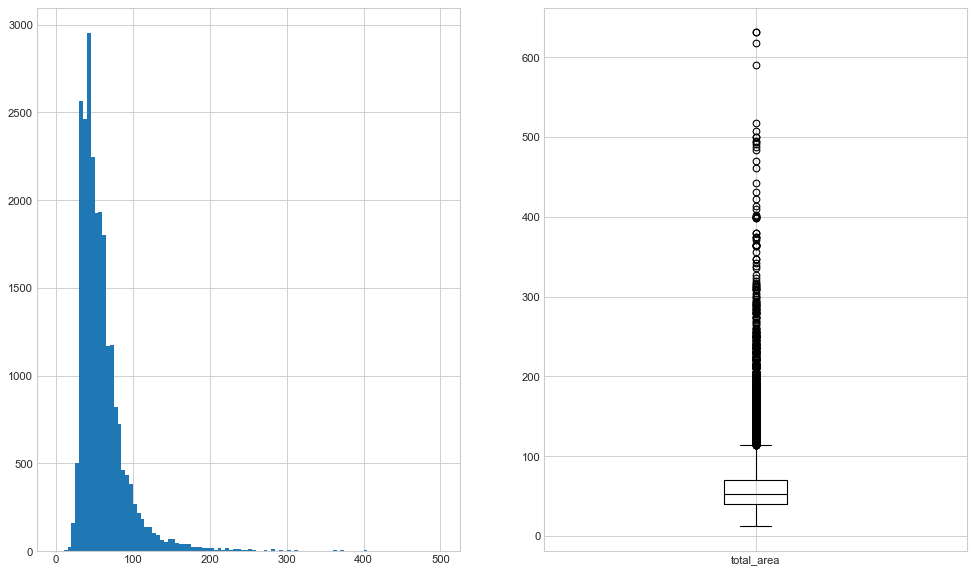

In [128]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9), dpi= 80)

df['total_area'].hist(range=(0, 500), bins=100, ax=ax1);
df.boxplot(column=['total_area'], color='black', ax=ax2);

Из гистограммы видно, что основную массу объектов составляют квартиры до 100 кв.м., причем квартиры до 50 кв.м., и от 50 до 100 кв.м. составляют примерно одинаковые доли. Далее, с ростом площади до 200 кв.м. количество квартир постепенно снижается, а за пределами 200 кв.м. уже наблюдаются совсем малочисленные объекты.  

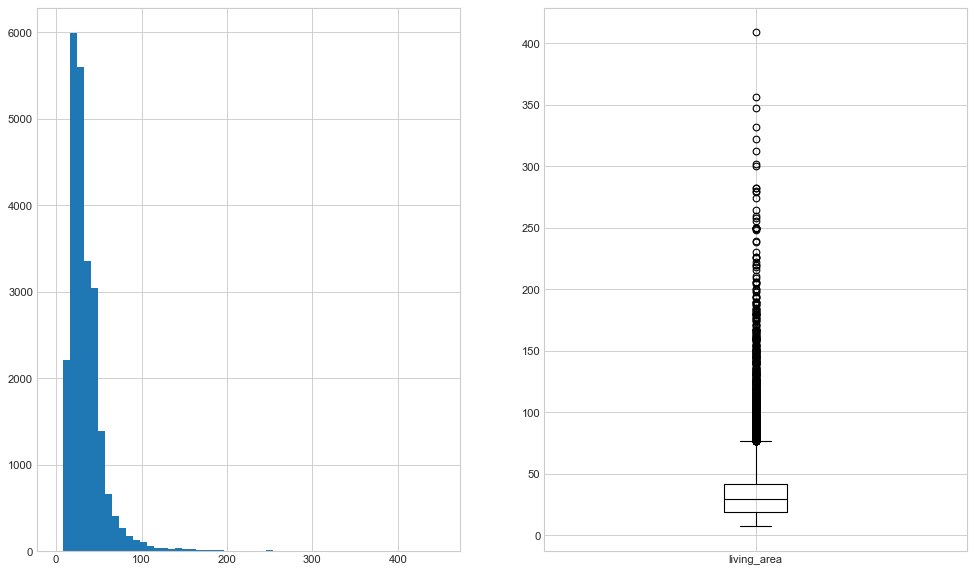

In [129]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9), dpi= 80)

df['living_area'].hist(range=(0, 450), bins=55, ax=ax1);
df.boxplot(column=['living_area'], color='black', ax=ax2);

Наибольшее количество квартир сосредоточено в районе 50 кв.м. жилой площади (приблизительно половина от наиболее частотной величины общей площади). Есть выбросы.

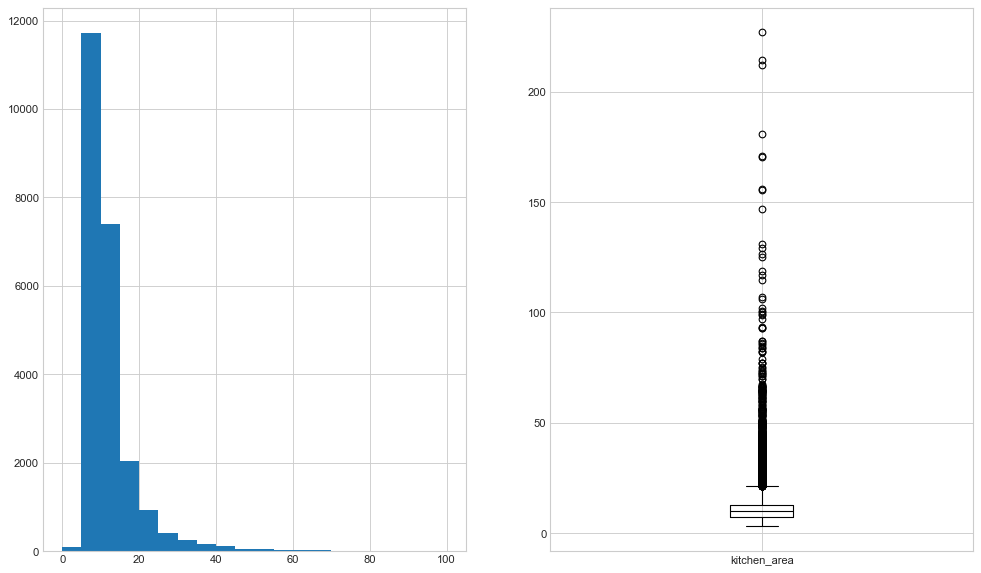

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9), dpi= 80)

df['kitchen_area'].hist(range=(0, 100), bins=20, ax=ax1);
df.boxplot(column=['kitchen_area'], color='black', ax=ax2);

Примерно похожая ситуация и с площадью кухни, есть пик на гистограмме, позволяющий определить преобладание объектов с кухнями в пределах не более 10 кв.м., чуть меньше объектов с кухнями от 10 до 15 кв.м., далее, с ростом площади количество квартир начинает уменьшаться. За пределами значения площади примерно в 22-25 кв.м. можно наблюдать предположительные выбросы.

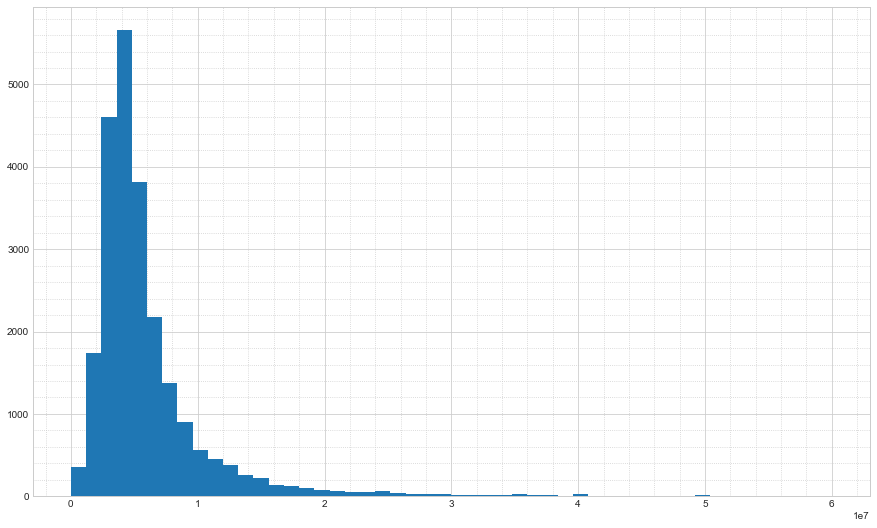

In [131]:
df['last_price'].hist(bins=50, range=(0, 60000000), figsize=(15, 9))
plt.minorticks_on()
plt.grid(which='minor',
        linestyle = ':');

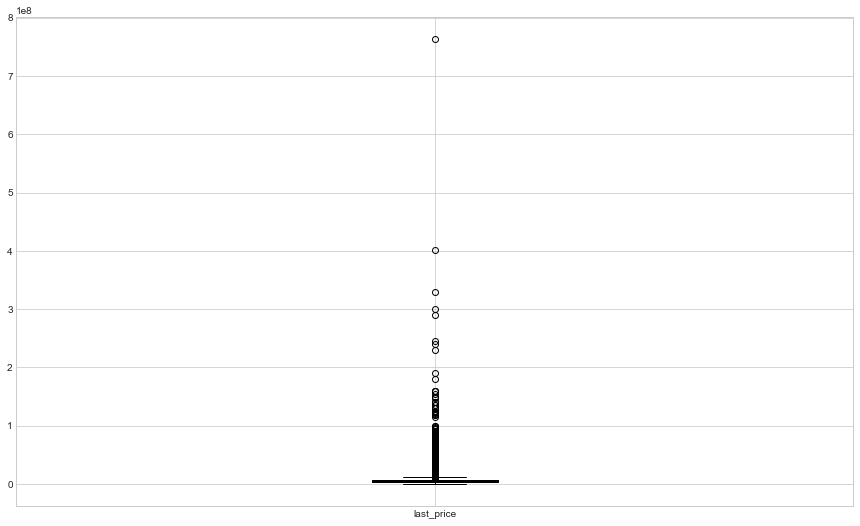

In [132]:
df.boxplot(column=['last_price'], color='black', figsize=(15, 9));

In [133]:
df['last_price'].quantile(0.25), df['last_price'].quantile(0.925)

(3400000.0, 12700000.0)

In [134]:
IQR = df['last_price'].quantile(0.925) - df['last_price'].quantile(0.25)
IQR

9300000.0

In [135]:
# Правая граница адекватности

df['last_price'].quantile(0.925) + 1.5 * IQR

26650000.0

Гистограмма с длинным правым "хвостом" дает представление о явных выбросах в данных признака цены объектов. Квартиры, с ценой выше 27 млн. уже можно отнести к выбросам (Q3 + 1,5IQR).

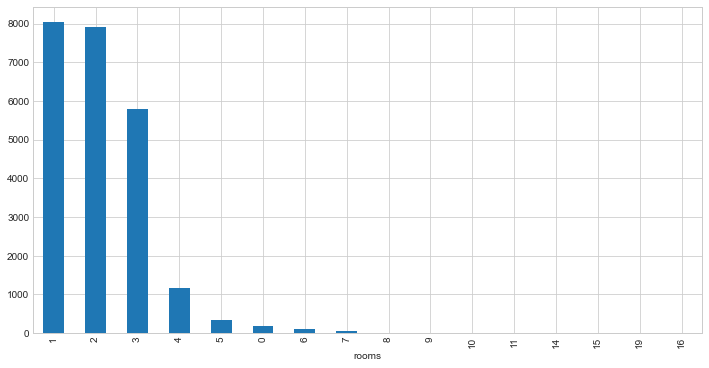

In [136]:
df['rooms'].value_counts().plot(kind='bar', figsize=(12, 6));

Преобладают однокомнатные и двукхкомнатные квартиры (около 8000 шт.), трехкомнатных квартир чуть меньше, приблизительно 6000 шт., квартиры с большим количеством комнат встречаются значительно реже.

In [137]:
df['ceiling_height'].describe()

count    14476.000000
mean         2.727838
std          0.292330
min          2.000000
25%          2.510000
50%          2.650000
75%          2.800000
max          8.300000
Name: ceiling_height, dtype: float64

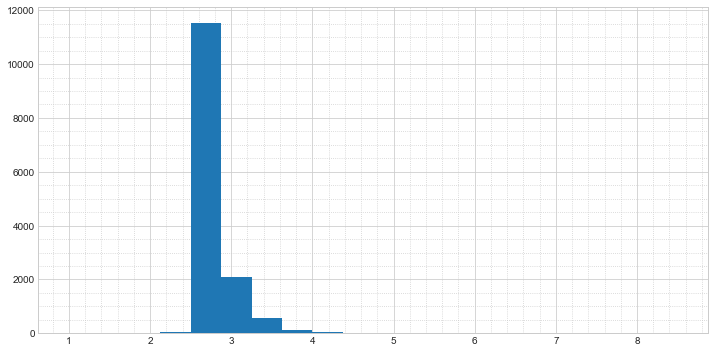

In [138]:
df['ceiling_height'].hist(range=(1, 8.5), bins=20, figsize=(12, 6));
plt.minorticks_on()
plt.grid(which='minor',
        linestyle = ':');

Основная масса квартир имеет высоту потолков в диапазоне от 2.5 до 3 метров (около 12000 объектов), реже (более, чем в два раза) встречаются квартиры с потолками от 3 до 3.5 метров.

* Изучим следующие параметры объектов: этаж квартиры, тип этажа квартиры, общее количество этажей в доме.

In [139]:
df[['floor', 'floors_total_without_nan', 'floor_category']].head(10)

,floor,floors_total_without_nan,floor_category
0,8,16,другой
1,1,11,первый
2,4,5,другой
3,9,14,другой
4,13,14,другой
5,5,12,другой
6,6,26,другой
7,22,24,другой
8,26,27,другой
9,7,9,другой


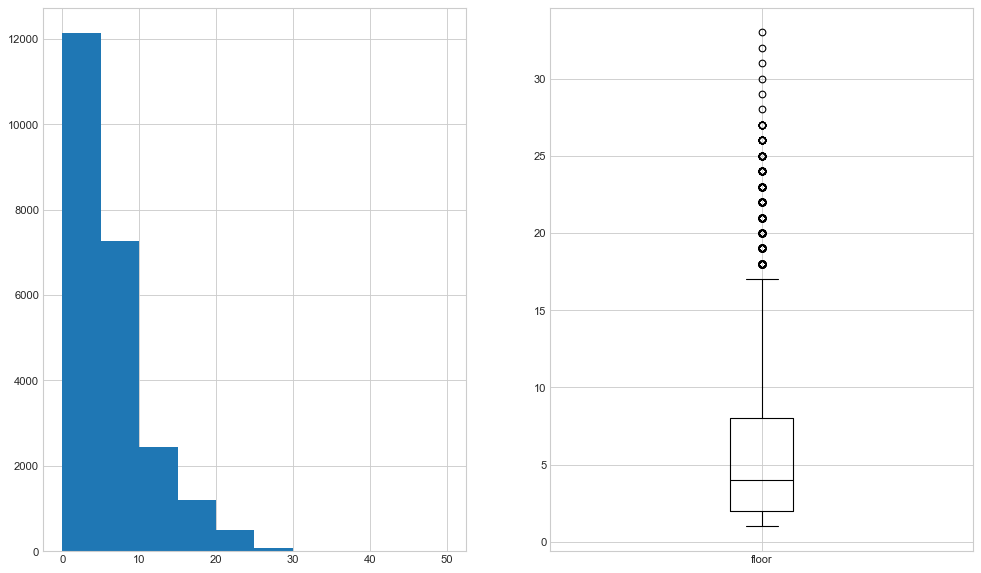

In [140]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9), dpi= 80)

df['floor'].hist(range=(0, 50), ax=ax1);
df.boxplot(column=['floor'], color='black', ax=ax2);

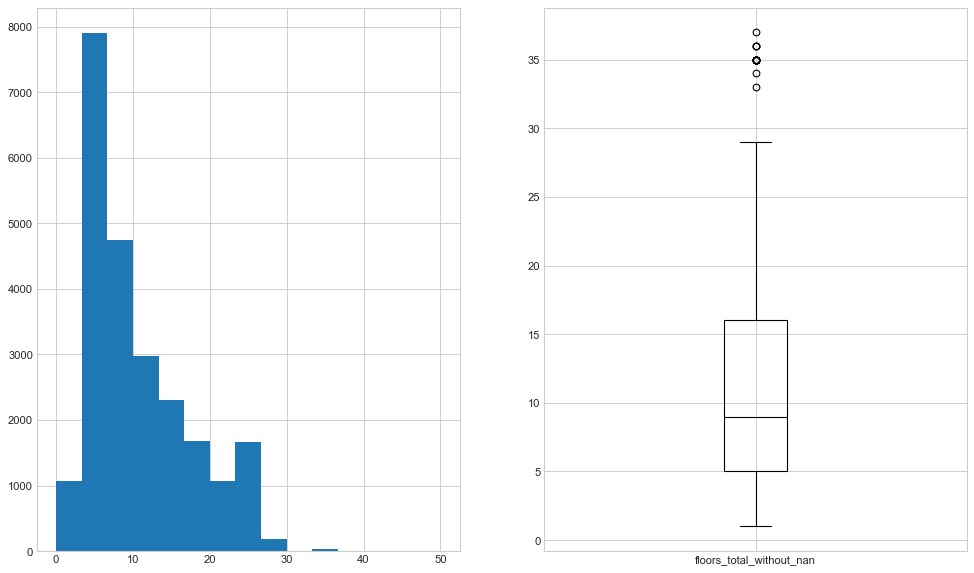

In [141]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9), dpi= 80)

df['floors_total_without_nan'].hist(range=(0, 50), bins=15, ax=ax1);
df.boxplot(column=['floors_total_without_nan'], color='black', ax=ax2);

In [142]:
df.groupby('floor_category').agg({'floor': ['count', 'mean', 'median']})

floor                 
                count      mean median
floor_category                        
другой          17402  6.464889    5.0
первый           2910  1.000000    1.0
последний        3326  7.165364    5.0

Большинство квартир располагается на этажах вплоть до пятого (около 12000 шт.), чуть меньше объектов, около 7000 шт., расположены на этажах с 5 по 10, далее, с ростом номера этажа, количество квартир уменьшается. Примерно похожая ситуация наблюдается с общей этажностью (преобладают 5-10 этажные дома). Объекты на первом и последнем этажах распределены по количеству примерно одинаково, больше всего квартир относится к категории "другой" этаж.

* Изучим следующие параметры объектов: расстояние до центра города в метрах, расстояние до ближайшего аэропорта, расстояние до ближайшего парка.

In [143]:
df[['city_centers_nearest', 'airports_nearest', 'parks_nearest']].describe()

,city_centers_nearest,airports_nearest,parks_nearest
count,18128.000000,18105.000000,8056.000000
mean,14198.615126,28802.352499,490.785005
std,8604.423618,12636.390927,342.663503
min,181.000000,0.000000,1.000000
25%,9247.000000,18574.000000,287.750000
50%,13107.000000,26755.000000,454.000000
75%,16293.000000,37310.000000,612.000000
max,65968.000000,84869.000000,3190.000000


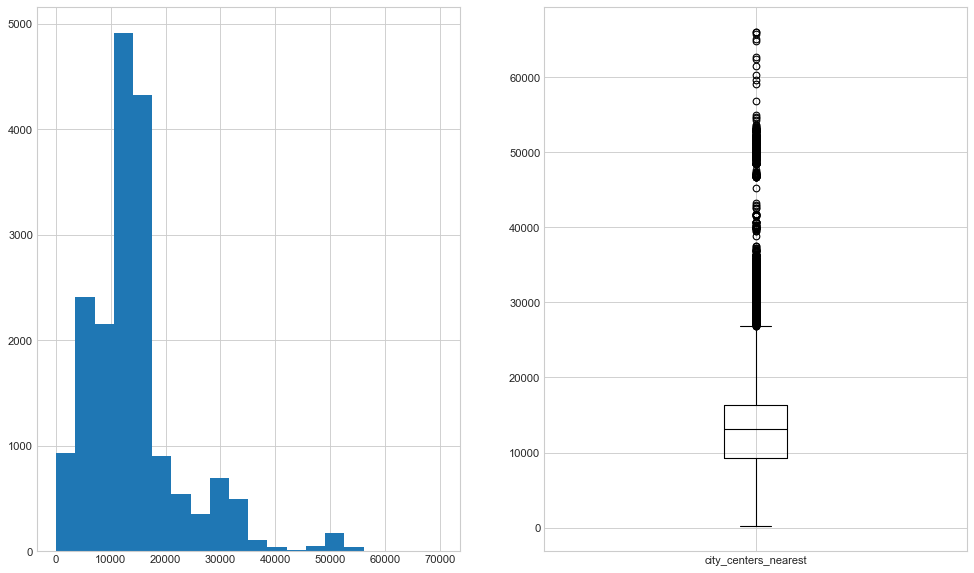

In [144]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9), dpi= 80)

df['city_centers_nearest'].hist(range=(100, 70000), bins=20, ax=ax1);
df.boxplot(column=['city_centers_nearest'], color='black', ax=ax2);

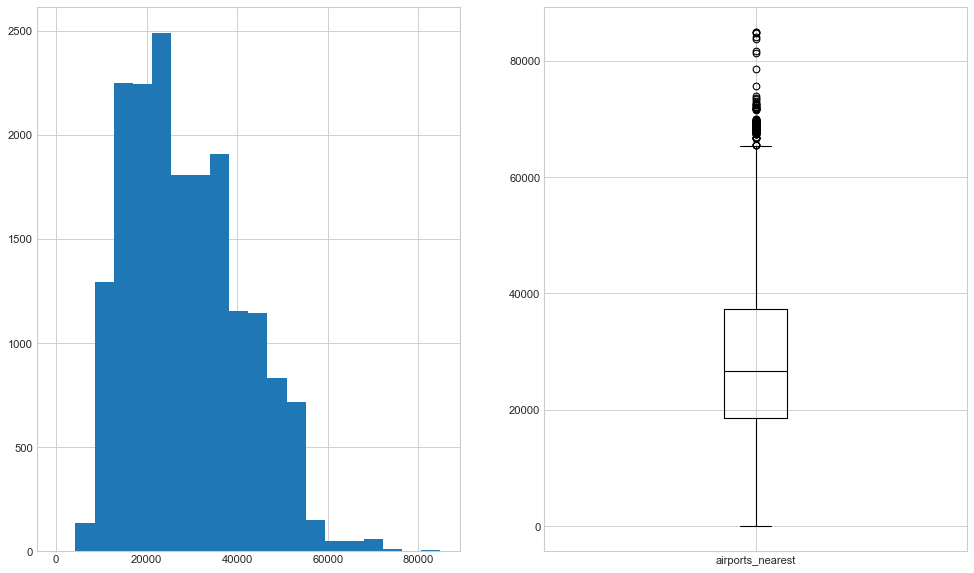

In [145]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9), dpi= 80)

df['airports_nearest'].hist(bins=20, ax=ax1);
df.boxplot(column=['airports_nearest'], color='black', ax=ax2);

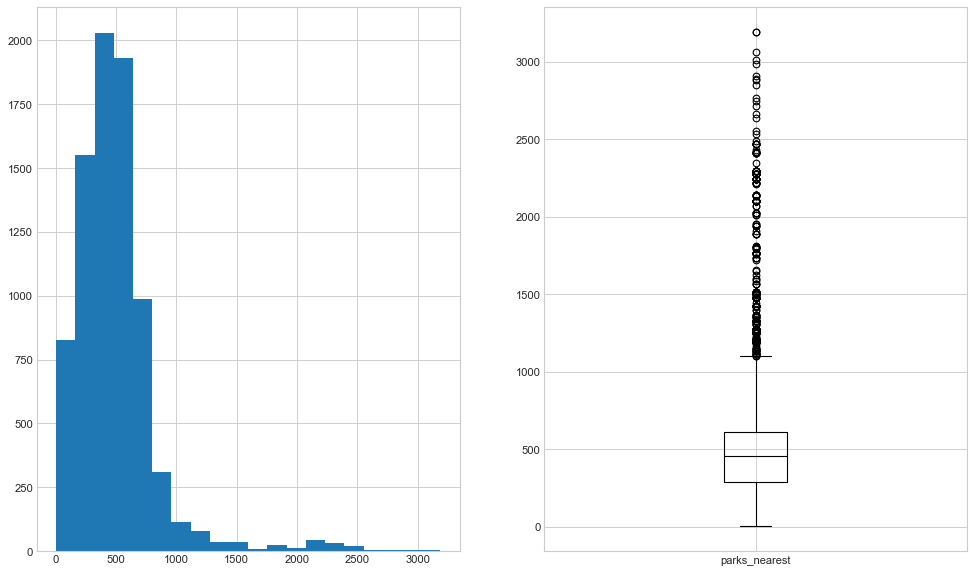

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9), dpi= 80)

df['parks_nearest'].hist(bins=20, ax=ax1);
df.boxplot(column=['parks_nearest'], color='black', ax=ax2);

Что касается признака расстояния до центра - наиболее частотными являются объявления о продаже квартир, расположенных в пределах 10-18 км. от центра. Квартир, располеженных непосредственно в центре (до 5 км.) значительно меньше, около 1000 шт., такая же тенденция - к снижению количества объектов, наблюдается и при удалении от центра более чем на 18 км. Для признака "расстояние до ближ. аэропорта" характерно похожее поведение: рост количества объектов до "пика" в 2500 шт. на расстоянии 20-25 км. до аэропорта, затем, достаточно постепенное снижение их количества, а уже после 65 км. - остается совсем немного, относительно общей массы, квартир. По паркам - чаще всего встречаются квартиры, расположенные на расстоянии 300-500 м. от какого-либо парка, немного меньше объектов, расположенных в диапазоне 500-750 м. Совсем малочисленны квартиры, распол. от парков на расстоянии около 1250 м. и более.

* Изучим следующие параметры объектов: день и месяц публикации объявления.

In [147]:
df[['first_exposition_day_week', 'first_exposition_month']].describe()

,first_exposition_day_week,first_exposition_month
count,23638.000000,23638.000000
mean,2.568914,6.401472
std,1.788746,3.491400
min,0.000000,1.000000
25%,1.000000,3.000000
50%,3.000000,6.000000
75%,4.000000,10.000000
max,6.000000,12.000000


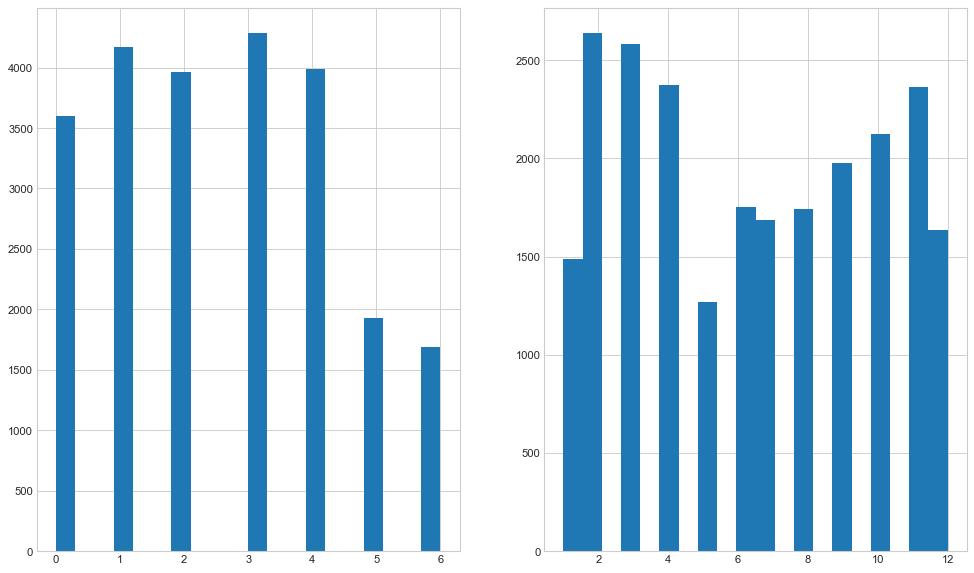

In [148]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9), dpi= 80)

df['first_exposition_day_week'].hist(bins=20, ax=ax1);
df['first_exposition_month'].hist(bins=20, ax=ax2);

Распределение количества публикаций объявлений в зависимости от дня недели выглядит более менее равномерно для дней недели с пн по пт (количество публикаций в диапазоне 3500 - 4500 шт.), на выходных есть тенденции к уменьшению публикаций (< 2000 шт.)
В случае, если рассматривать в разрезе привязки к месяцам - наибольшая активность зимой\осенью, спад - весной\летом.

* Изучим, как быстро продавались квартиры (признак days_exposition).

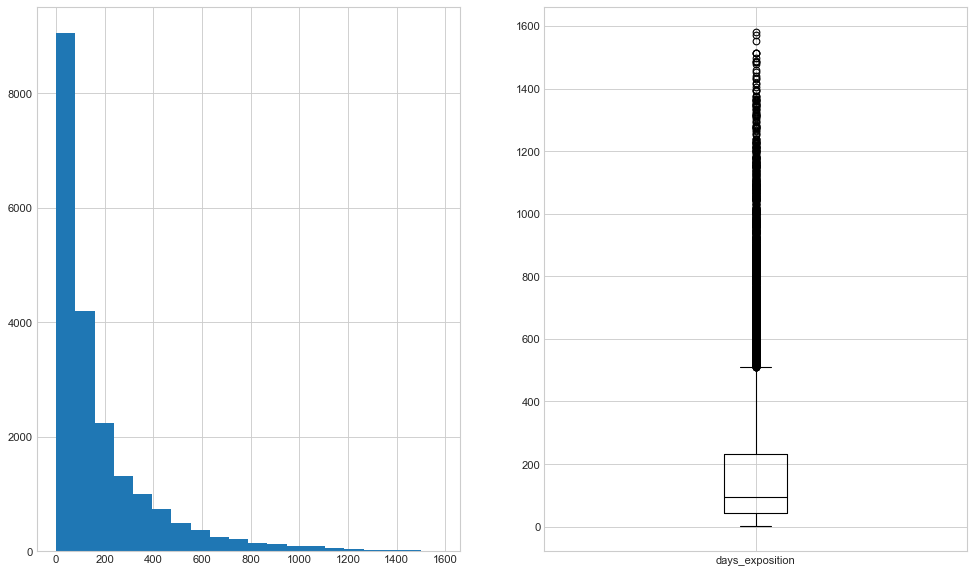

In [149]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9), dpi= 80)

df['days_exposition'].hist(bins=20, ax=ax1);
df.boxplot(column=['days_exposition'], color='black', ax=ax2);

Выведем информацию об основных статистиках, в том числе о среднем и медиане:

In [150]:
df['days_exposition'].describe()

count    20458.000000
mean       180.795483
std        219.827278
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Среднее время продажи составляет приблизительно 181 день, а медиана - 95, такая разница обусловлена наличием выбросов в большую сторону, что подтвержает и гистограмма. Судя по "ящику с усами" значения превышающие, приблизительно, 500-510 дней уже можно считать выбросами. Чаще всего квартиры продаются в течение не более 50 дней, далее, с увеличением количества дней, идёт тенденция на постепенное уменьшение количества снятых с публикации квартир, есть квартиры срок продажи которых составляет более года, более двух лет и даже трёх. Максимальная продолжительность продажи 1580 дней, т.е. больше 4-х лет.  

Исследуем, какие факторы больше всего влияют на общую (полную) стоимость объекта? 

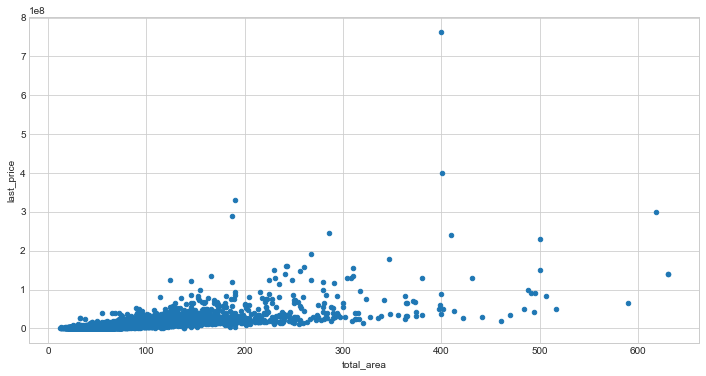

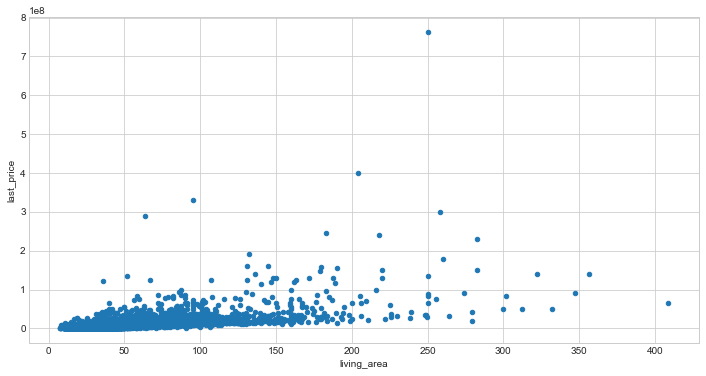

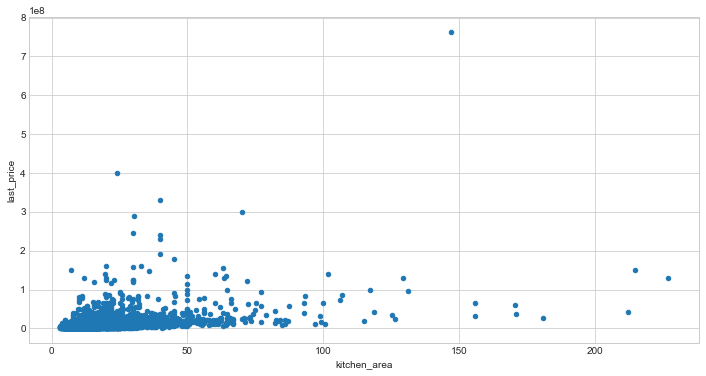

In [151]:
df.plot(x='total_area', y='last_price', kind='scatter', figsize=(12, 6), grid=True);
df.plot(x='living_area', y='last_price', kind='scatter', figsize=(12, 6), grid=True);
df.plot(x='kitchen_area', y='last_price', kind='scatter', figsize=(12, 6), grid=True);

In [152]:
corr_total = df['total_area'].corr(df['last_price']).round(2)
corr_living = df['living_area'].corr(df['last_price']).round(2)
corr_kitchen = df['kitchen_area'].corr(df['last_price']).round(2)

print(f'Коэффициент корреляции между total_area и last_price: {corr_total}')
print(f'Коэффициент корреляции между living_area и last_price: {corr_living}')
print(f'Коэффициент корреляции между kitchen_area и last_price: {corr_kitchen}')

Коэффициент корреляции между total_area и last_price: 0.64
Коэффициент корреляции между living_area и last_price: 0.58
Коэффициент корреляции между kitchen_area и last_price: 0.46


Самая "сильная" связь (положительная корреляция) между ценой и общей площадью (в разрезе сравнения с тремя указанными признаками).

При изучении связи цены и признаков `rooms`, `floor_category`, `first_exposition_day_week`, `first_exposition_month`, `first_exposition_year` сгруппируем данные по категориям, вычислим среднее и медиану стоимости, построим линейные графики для каждой пары "цена - иссл. признак":

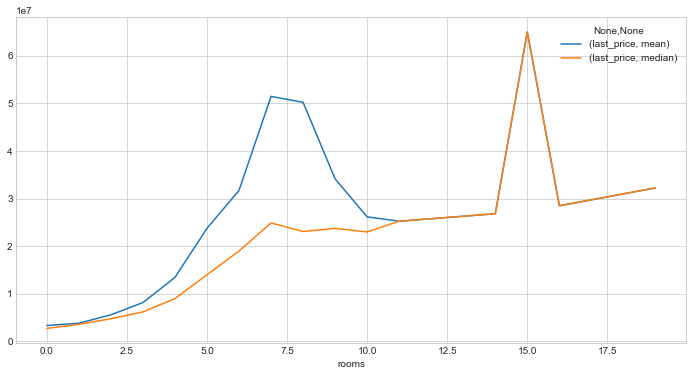

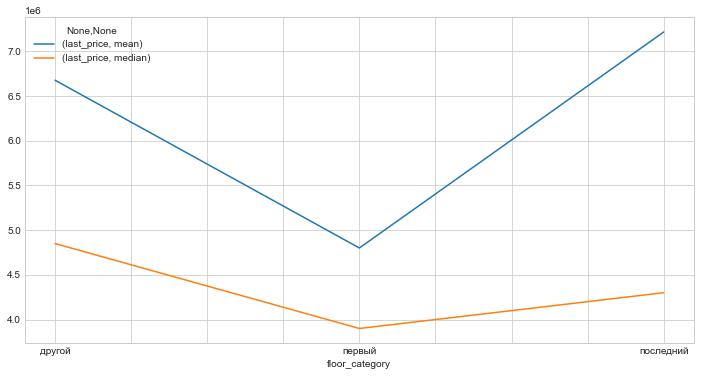

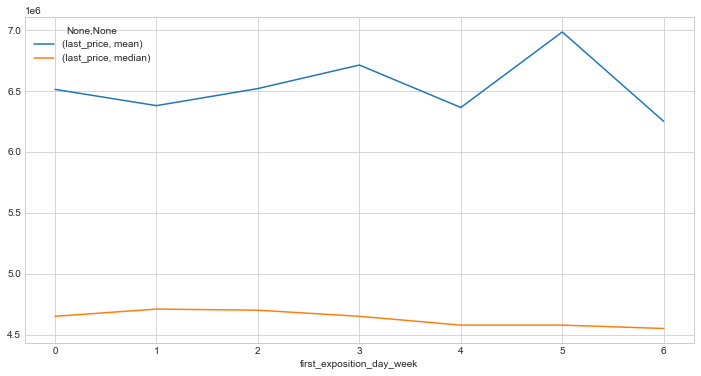

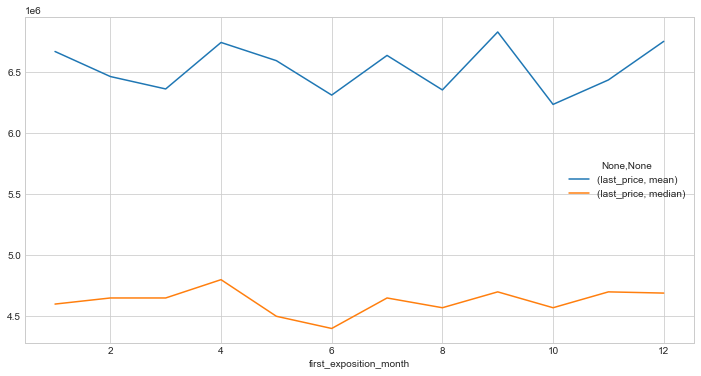

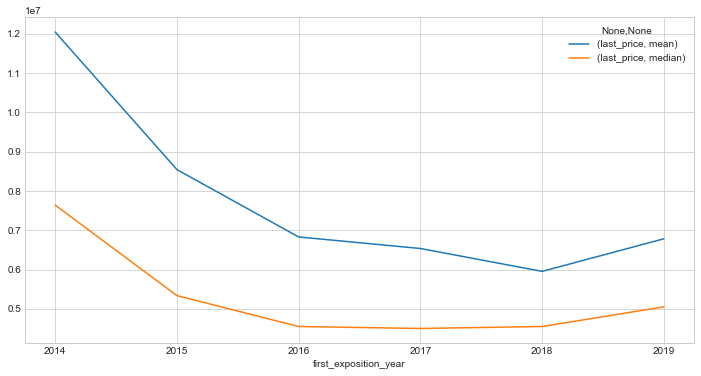

In [153]:
for i in ['rooms', 'floor_category', 'first_exposition_day_week', 'first_exposition_month', 'first_exposition_year']:
    df.groupby(i).agg({'last_price': ['mean', 'median']}).plot(kind='line', figsize=(12, 6));

При увеличении количества комнат до уровня 7 происходит рост цены, далее наблюдается спад, за исключением скачка на уровне 15 (шт. комнат), видимо обусловленного наличием выбросов. Стоимость квартир на первом этаже ниже, чем для этажей двух других категорий. Относительно влияния месяца и дня недели на стоимость есть сомнения, графики, хоть и не идеально, но стремятся к постоянным, большой разброс между средним и медианой. Наблюдается падение цен с 2014 года (максимум) до 2016, далее - стабилизация, плюс-минус, на одном уровне.

* Найдём среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра (столбец `locality_name`).

Отберём населённые пункты с наибольшим числом объявлений, вычислим для них среднюю стоимость одного кв. метра:

In [154]:
(
    df
    .pivot_table(index='locality_name', values='price_per_meter', aggfunc=['count', 'mean'])
    .droplevel(1, axis=1)
    .sort_values(by='count', ascending=False)
    .head(10)
)

,count,mean
locality_name,,
Санкт-Петербург,15711,114775.093177
Мурино,589,86061.675891
Кудрово,472,95324.928602
поселок Шушары,440,78677.363636
Всеволожск,398,68654.475628
Пушкин,369,103125.818157
Колпино,338,75424.581953
поселок Парголово,327,90175.915291
Гатчина,307,68746.147231


Как видим, и по количеству объявлений, и по средней цене за квадратный метр лидирует Санкт-Петербург, в конце десятки - Выборг.

Ранее найдено расстояние до центра в километрах. Теперь выделим квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислим среднюю цену каждого километра. Опишем, как стоимость объектов зависит от расстояния до центра города.

In [155]:
df_spb = df.loc[df['locality_name'] == 'Санкт-Петербург']
df_spb.head()

,last_price,rooms,total_area,living_area,kitchen_area,ceiling_height,balcony,is_apartment,studio,open_plan,floor,floors_total,floors_total_without_nan,total_images,first_day_exposition,days_exposition,locality_name,city_centers_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,price_per_meter,first_exposition_day_week,first_exposition_month,first_exposition_year,floor_category,city_centers_nearest_km
0,13000000.0,3,108.0,51.000000,25.000000,2.70,NaN,False,False,False,8,16.0,16,20,2019-03-07,NaN,Санкт-Петербург,16028.0,18863.0,1.0,482.0,2.0,755.0,120370.4,3,3,2019,другой,16.0
2,5196000.0,2,56.0,34.300000,8.300000,NaN,0.0,False,False,False,4,5.0,5,10,2015-08-20,558.0,Санкт-Петербург,13933.0,21741.0,1.0,90.0,2.0,574.0,92785.7,3,8,2015,другой,14.0
3,64900000.0,3,159.0,89.830508,66.169492,NaN,0.0,False,False,False,9,14.0,14,0,2015-07-24,424.0,Санкт-Петербург,6800.0,28098.0,2.0,84.0,3.0,234.0,408176.1,4,7,2015,другой,7.0
4,10000000.0,2,100.0,32.000000,41.000000,3.03,NaN,False,False,False,13,14.0,14,2,2018-06-19,121.0,Санкт-Петербург,8098.0,31856.0,2.0,112.0,1.0,48.0,100000.0,1,6,2018,другой,8.0
7,7915000.0,2,71.6,40.451977,18.900000,NaN,2.0,False,False,False,22,24.0,24,5,2019-04-18,NaN,Санкт-Петербург,11634.0,23982.0,0.0,NaN,0.0,NaN,110544.7,3,4,2019,другой,12.0


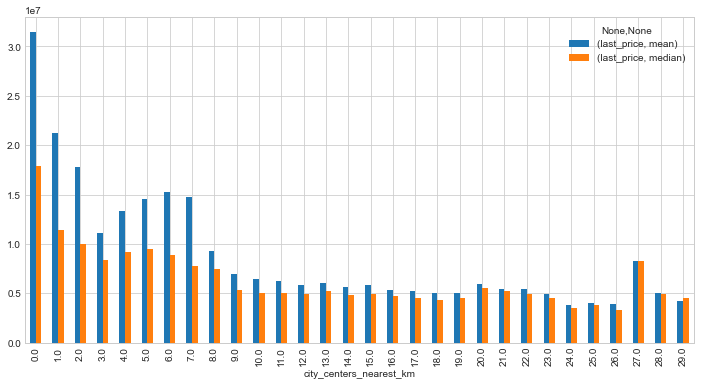

In [156]:
df_spb.groupby('city_centers_nearest_km').agg({'last_price': ['mean', 'median']}).plot(kind='bar', figsize=(12, 6));

В центре и непосредственной близости от него (< 9 км.) недвижимость дороже. Также, в пределах до 9 км. от центра, есть различия медианного и среднего значения цены, видимо, в виду наличия существенного разброса по ценам, тогда как, чем дальше от центра, тем меньше становятся различия между медианой и средним.

#### Вывод:
Изучены основные параметры объектов, построены гистограммы. Рассмотрена динамика продажи в разрезе количества дней размещения объявлений до их снятия с публикации. Определены параметры, наиболее коррелирующие с ценой, такие как: общая площадь квартиры, количество комнат, год продажи, удалённость от центра. Определена область (населенный пункт, удаленность от центра), в которой преобладает наибольшая стоимость продажи.

### Общий вывод

Проведён первичный анализ данных. Там, где это было возможно, устранены пропуски и обработаны нетипичные(аномальные) значения ряда признаков. Посчитаны и добавлены новые признаки, позволяющие более детально изучить данные и наличие/отсутствие зависимостей между параметрами: цена одного квадратного метра; день недели, месяц и год публикации объявления; тип этажа квартиры; расстояние до центра города в км. Произведен исследовательский анализ данных, в результате которого выявлены статистические характеристики (среднее, медиана) ряда признаков, изучены и определены показатели, находящиеся в наибольшей взимосвязи с ценой продажи.